<a href="https://colab.research.google.com/github/0xLighty/lesion_detection/blob/main/image_Segmentation_resunet_unet_resunet%2B%2B_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d jy2040/kvasit-seg-train-test-valid

 99% 552M/558M [00:03<00:00, 219MB/s]
100% 558M/558M [00:03<00:00, 187MB/s]


In [2]:
!unzip /content/kvasit-seg-train-test-valid.zip -d /content/kvasit-seg-train-test-valid

Streaming output truncated to the last 5000 lines.
  inflating: /content/kvasit-seg-train-test-valid/content/new_data/Kvasir-SEG/train/masks/cju7g7ba42z310987bqzbi2bq_13.jpg  
  inflating: /content/kvasit-seg-train-test-valid/content/new_data/Kvasir-SEG/train/masks/cju7g7ba42z310987bqzbi2bq_14.jpg  
  inflating: /content/kvasit-seg-train-test-valid/content/new_data/Kvasir-SEG/train/masks/cju7g7ba42z310987bqzbi2bq_15.jpg  
  inflating: /content/kvasit-seg-train-test-valid/content/new_data/Kvasir-SEG/train/masks/cju7g7ba42z310987bqzbi2bq_16.jpg  
  inflating: /content/kvasit-seg-train-test-valid/content/new_data/Kvasir-SEG/train/masks/cju7g7ba42z310987bqzbi2bq_17.jpg  
  inflating: /content/kvasit-seg-train-test-valid/content/new_data/Kvasir-SEG/train/masks/cju7g7ba42z310987bqzbi2bq_18.jpg  
  inflating: /content/kvasit-seg-train-test-valid/content/new_data/Kvasir-SEG/train/masks/cju7g7ba42z310987bqzbi2bq_19.jpg  
  inflating: /content/kvasit-seg-train-test-valid/content/new_data/Kvasir-

In [3]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from glob import glob
from tensorflow.keras.metrics import Precision, Recall, MeanIoU
from tensorflow.keras.optimizers import Adam, Nadam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [4]:
def parse_image(img_path, image_size):
    image_rgb = cv2.imread(img_path, 1)
    h, w, _ = image_rgb.shape
    if (h == image_size) and (w == image_size):
        pass
    else:
        image_rgb = cv2.resize(image_rgb, (image_size, image_size))
    image_rgb = image_rgb/255.0
    return image_rgb

def parse_mask(mask_path, image_size):
    mask = cv2.imread(mask_path, -1)
    h, w = mask.shape
    if (h == image_size) and (w == image_size):
        pass
    else:
        mask = cv2.resize(mask, (image_size, image_size))
    mask = np.expand_dims(mask, -1)
    mask = mask/255.0

    return mask


In [5]:
class DataGen(tf.keras.utils.Sequence):
    def __init__(self, image_size, images_path, masks_path, batch_size=8):
        self.image_size = image_size
        self.images_path = images_path
        self.masks_path = masks_path
        self.batch_size = batch_size
        self.on_epoch_end()

    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.images_path):
            self.batch_size = len(self.images_path) - index*self.batch_size

        images_path = self.images_path[index*self.batch_size : (index+1)*self.batch_size]
        masks_path = self.masks_path[index*self.batch_size : (index+1)*self.batch_size]

        images_batch = []
        masks_batch = []

        for i in range(len(images_path)):
            ## Read image and mask
            image = parse_image(images_path[i], self.image_size)
            mask = parse_mask(masks_path[i], self.image_size)

            images_batch.append(image)
            masks_batch.append(mask)

        return np.array(images_batch), np.array(masks_batch)

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.images_path)/float(self.batch_size)))


### Resunet++

In [7]:
def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def stem_block(x, n_filter, strides):
    x_init = x

    ## Conv 1
    x = Conv2D(n_filter, (3, 3), padding="same", strides=strides)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same")(x)

    ## Shortcut
    s  = Conv2D(n_filter, (1, 1), padding="same", strides=strides)(x_init)
    s = BatchNormalization()(s)

    ## Add
    x = Add()([x, s])
    x = squeeze_excite_block(x)
    return x


def resnet_block(x, n_filter, strides=1):
    x_init = x

    ## Conv 1
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=strides)(x)
    ## Conv 2
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=1)(x)

    ## Shortcut
    s  = Conv2D(n_filter, (1, 1), padding="same", strides=strides)(x_init)
    s = BatchNormalization()(s)

    ## Add
    x = Add()([x, s])
    x = squeeze_excite_block(x)
    return x

def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(6 * rate_scale, 6 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x2, x3, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(y)
    return y

def attetion_block(g, x):
    """
        g: Output of Parallel Encoder block
        x: Output of Previous Decoder block
    """

    filters = x.shape[-1]

    g_conv = BatchNormalization()(g)
    g_conv = Activation("relu")(g_conv)
    g_conv = Conv2D(filters, (3, 3), padding="same")(g_conv)

    g_pool = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(g_conv)

    x_conv = BatchNormalization()(x)
    x_conv = Activation("relu")(x_conv)
    x_conv = Conv2D(filters, (3, 3), padding="same")(x_conv)

    gc_sum = Add()([g_pool, x_conv])

    gc_conv = BatchNormalization()(gc_sum)
    gc_conv = Activation("relu")(gc_conv)
    gc_conv = Conv2D(filters, (3, 3), padding="same")(gc_conv)

    gc_mul = Multiply()([gc_conv, x])
    return gc_mul


In [21]:
class ResUnetPlusPlus:
    def __init__(self, input_size=256):
        self.input_size = input_size

    def build_model(self):
        n_filters = [16, 32, 64, 128, 256]
        inputs = Input((self.input_size, self.input_size, 3))

        c0 = inputs
        c1 = stem_block(c0, n_filters[0], strides=1)

        ## Encoder
        c2 = resnet_block(c1, n_filters[1], strides=2)
        c3 = resnet_block(c2, n_filters[2], strides=2)
        c4 = resnet_block(c3, n_filters[3], strides=2)

        ## Bridge
        b1 = aspp_block(c4, n_filters[4])

        ## Decoder
        d1 = attetion_block(c3, b1)
        d1 = UpSampling2D((2, 2))(d1)
        d1 = Concatenate()([d1, c3])
        d1 = resnet_block(d1, n_filters[3])

        d2 = attetion_block(c2, d1)
        d2 = UpSampling2D((2, 2))(d2)
        d2 = Concatenate()([d2, c2])
        d2 = resnet_block(d2, n_filters[2])

        d3 = attetion_block(c1, d2)
        d3 = UpSampling2D((2, 2))(d3)
        d3 = Concatenate()([d3, c1])
        d3 = resnet_block(d3, n_filters[1])

        ## output
        outputs = aspp_block(d3, n_filters[0])
        outputs = Conv2D(1, (1, 1), padding="same")(outputs)
        outputs = Activation("sigmoid")(outputs)

        ## Model
        model = Model(inputs, outputs)
        return model


In [9]:
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [10]:
import os
os.mkdir("/content/files")

In [ ]:
## Path
file_path = "/content/files/"
model_path = "/content/files/resunetplusplus.h5"

## Create files folder
try:
    os.mkdir("files")
except:
    pass

train_path = "/content/kvasit-seg-train-test-valid/content/new_data/Kvasir-SEG/train/"
valid_path = "/content/kvasit-seg-train-test-valid/content/new_data/Kvasir-SEG/valid/"

## Training
train_image_paths = glob(os.path.join(train_path, "images", "*"))
train_mask_paths = glob(os.path.join(train_path, "masks", "*"))
train_image_paths.sort()
train_mask_paths.sort()

# train_image_paths = train_image_paths[:2000]
# train_mask_paths = train_mask_paths[:2000]

## Validation
valid_image_paths = glob(os.path.join(valid_path, "images", "*"))
valid_mask_paths = glob(os.path.join(valid_path, "masks", "*"))
valid_image_paths.sort()
valid_mask_paths.sort()

## Parameters
image_size = 256
batch_size = 8
lr = 1e-4
epochs = 10

train_steps = len(train_image_paths)//batch_size
valid_steps = len(valid_image_paths)//batch_size

## Generator
train_gen = DataGen(image_size, train_image_paths, train_mask_paths, batch_size=batch_size)
valid_gen = DataGen(image_size, valid_image_paths, valid_mask_paths, batch_size=batch_size)

## Unet
#arch = Unet(input_size=image_size)
#model = arch.build_model()

## ResUnet
#arch = ResUnet(input_size=image_size)
#model = arch.build_model()

## ResUnet++
arch = ResUnetPlusPlus(input_size=image_size)
model = arch.build_model()

optimizer = tf.keras.optimizers.Nadam(lr)
metrics = [Recall(), Precision(), dice_coef, MeanIoU(num_classes=2)]
model.compile(loss=dice_loss, optimizer=optimizer, metrics=metrics)

csv_logger = CSVLogger(f"{file_path}resunetplusplus_{batch_size}.csv", append=False)
checkpoint = ModelCheckpoint(model_path, verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
callbacks = [csv_logger, checkpoint, reduce_lr, early_stopping]

model.fit_generator(train_gen,
        validation_data=valid_gen,
        steps_per_epoch=train_steps,
        validation_steps=valid_steps,
        epochs=epochs,
        callbacks=callbacks)


Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


3100/3100 [==============================] - ETA: 0s - loss: 0.5037 - recall: 0.6468 - precision: 0.4632 - dice_coef: 0.4963 - mean_io_u: 0.5617
Epoch 1: val_loss improved from inf to 0.50703, saving model to /content/files/resunetplusplus.h5
3100/3100 [==============================] - 1325s 417ms/step - loss: 0.5037 - recall: 0.6468 - precision: 0.4632 - dice_coef: 0.4963 - mean_io_u: 0.5617 - val_loss: 0.5070 - val_recall: 0.3494 - val_precision: 0.7052 - val_dice_coef: 0.4930 - val_mean_io_u: 0.5124 - lr: 1.0000e-04
Epoch 2/10
3100/3100 [==============================] - ETA: 0s - loss: 0.4257 - recall: 0.6444 - precision: 0.5806 - dice_coef: 0.5743 - mean_io_u: 0.6135
Epoch 2: val_loss improved from 0.50703 to 0.34427, saving model to /content/files/resunetplusplus.h5
3100/3100 [==============================] - 1296s 418ms/step - loss: 0.4257 - recall: 0.6444 - precision: 0.5806 - dice_coef: 0.5743 - mean_io_u: 0.6135 - val_loss: 0.3443 - val_recall: 0.7619 - val_precision: 0.588

### UNet

In [20]:
class Unet:
    def __init__(self, input_size=256):
        self.input_size = input_size

    def build_model(self):
        def conv_block(x, n_filter, pool=True):
            x = Conv2D(n_filter, (3, 3), padding="same")(x)
            x = BatchNormalization()(x)
            x = Activation("relu")(x)

            x = Conv2D(n_filter, (3, 3), padding="same")(x)
            x = BatchNormalization()(x)
            x = Activation("relu")(x)
            c = x

            if pool == True:
                x = MaxPooling2D((2, 2), (2, 2))(x)
                return c, x
            else:
                return c

        n_filters = [16, 32, 64, 128, 256]
        inputs = Input((self.input_size, self.input_size, 3))

        c0 = inputs
        ## Encoder
        c1, p1 = conv_block(c0, n_filters[0])
        c2, p2 = conv_block(p1, n_filters[1])
        c3, p3 = conv_block(p2, n_filters[2])
        c4, p4 = conv_block(p3, n_filters[3])

        ## Bridge
        b1 = conv_block(p4, n_filters[4], pool=False)
        b2 = conv_block(b1, n_filters[4], pool=False)

        ## Decoder
        d1 = Conv2DTranspose(n_filters[3], (3, 3), padding="same", strides=(2, 2))(b2)
        d1 = Concatenate()([d1, c4])
        d1 = conv_block(d1, n_filters[3], pool=False)

        d2 = Conv2DTranspose(n_filters[3], (3, 3), padding="same", strides=(2, 2))(d1)
        d2 = Concatenate()([d2, c3])
        d2 = conv_block(d2, n_filters[2], pool=False)

        d3 = Conv2DTranspose(n_filters[3], (3, 3), padding="same", strides=(2, 2))(d2)
        d3 = Concatenate()([d3, c2])
        d3 = conv_block(d3, n_filters[1], pool=False)

        d4 = Conv2DTranspose(n_filters[3], (3, 3), padding="same", strides=(2, 2))(d3)
        d4 = Concatenate()([d4, c1])
        d4 = conv_block(d4, n_filters[0], pool=False)

        ## output
        outputs = Conv2D(1, (1, 1), padding="same")(d4)
        outputs = BatchNormalization()(outputs)
        outputs = Activation("sigmoid")(outputs)

        ## Model
        model = Model(inputs, outputs)
        return model

In [ ]:
## Path
file_path = "/content/files/"
model_path = "/content/files/unet.h5"

## Create files folder
try:
    os.mkdir("files")
except:
    pass

train_path = "/content/kvasit-seg-train-test-valid/content/new_data/Kvasir-SEG/train/"
valid_path = "/content/kvasit-seg-train-test-valid/content/new_data/Kvasir-SEG/valid/"

## Training
train_image_paths = glob(os.path.join(train_path, "images", "*"))
train_mask_paths = glob(os.path.join(train_path, "masks", "*"))
train_image_paths.sort()
train_mask_paths.sort()

# train_image_paths = train_image_paths[:2000]
# train_mask_paths = train_mask_paths[:2000]

## Validation
valid_image_paths = glob(os.path.join(valid_path, "images", "*"))
valid_mask_paths = glob(os.path.join(valid_path, "masks", "*"))
valid_image_paths.sort()
valid_mask_paths.sort()

## Parameters
image_size = 256
batch_size = 8
lr = 1e-4
epochs = 10

train_steps = len(train_image_paths)//batch_size
valid_steps = len(valid_image_paths)//batch_size

## Generator
train_gen = DataGen(image_size, train_image_paths, train_mask_paths, batch_size=batch_size)
valid_gen = DataGen(image_size, valid_image_paths, valid_mask_paths, batch_size=batch_size)


## Unet
arch = Unet(input_size=image_size)
model_unet = arch.build_model()

optimizer = tf.keras.optimizers.Nadam(lr)
metrics = [Recall(), Precision(), dice_coef, MeanIoU(num_classes=2)]
model_unet.compile(loss=dice_loss, optimizer=optimizer, metrics=metrics)

csv_logger = CSVLogger(f"{file_path}unet_{batch_size}.csv", append=False)
checkpoint = ModelCheckpoint(model_path, verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
callbacks = [csv_logger, checkpoint, reduce_lr, early_stopping]

hist_unet = model_unet.fit(train_gen,
        validation_data=valid_gen,
        steps_per_epoch=train_steps,
        validation_steps=valid_steps,
        epochs=epochs,
        callbacks=callbacks)


Epoch 1/10
3100/3100 [==============================] - ETA: 0s - loss: 0.6254 - recall_1: 0.8112 - precision_1: 0.4275 - dice_coef: 0.3746 - mean_io_u_1: 0.4141
Epoch 1: val_loss improved from inf to 0.54673, saving model to /content/files/unet.h5
3100/3100 [==============================] - 572s 181ms/step - loss: 0.6254 - recall_1: 0.8112 - precision_1: 0.4275 - dice_coef: 0.3746 - mean_io_u_1: 0.4141 - val_loss: 0.5467 - val_recall_1: 0.7588 - val_precision_1: 0.6495 - val_dice_coef: 0.4533 - val_mean_io_u_1: 0.4225 - lr: 1.0000e-04
Epoch 2/10
3100/3100 [==============================] - ETA: 0s - loss: 0.5625 - recall_1: 0.8205 - precision_1: 0.5542 - dice_coef: 0.4375 - mean_io_u_1: 0.4141
Epoch 2: val_loss improved from 0.54673 to 0.53846, saving model to /content/files/unet.h5
3100/3100 [==============================] - 568s 183ms/step - loss: 0.5625 - recall_1: 0.8205 - precision_1: 0.5542 - dice_coef: 0.4375 - mean_io_u_1: 0.4141 - val_loss: 0.5385 - val_recall_1: 0.9017 - v

In [ ]:
!zip -r /content/files.zip /content/files

  adding: content/files/ (stored 0%)
  adding: content/files/renunetplusplus_8.csv (deflated 49%)
  adding: content/files/resunetplusplus.h5 (deflated 9%)
  adding: content/files/unet_8.csv (deflated 53%)
  adding: content/files/.ipynb_checkpoints/ (stored 0%)
  adding: content/files/unet.h5 (deflated 9%)


In [ ]:
from google.colab import files
files.download('/content/files.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### ResUnet

In [13]:
class ResUnet:
    def __init__(self, input_size=256):
        self.input_size = input_size

    def build_model(self):
        def conv_block(x, n_filter):
            x_init = x

            ## Conv 1
            x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Conv2D(n_filter, (1, 1), padding="same")(x)
            ## Conv 2
            x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Conv2D(n_filter, (3, 3), padding="same")(x)
            ## Conv 3
            x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Conv2D(n_filter, (1, 1), padding="same")(x)

            ## Shortcut
            s  = Conv2D(n_filter, (1, 1), padding="same")(x_init)
            s = BatchNormalization()(s)

            ## Add
            x = Add()([x, s])
            return x

        def resnet_block(x, n_filter, pool=True):
            x1 = conv_block(x, n_filter)
            c = x1

            ## Pooling
            if pool == True:
                x = MaxPooling2D((2, 2), (2, 2))(x1)
                return c, x
            else:
                return c

        n_filters = [16, 32, 64, 96, 128]
        inputs = Input((self.input_size, self.input_size, 3))

        c0 = inputs
        ## Encoder
        c1, p1 = resnet_block(c0, n_filters[0])
        c2, p2 = resnet_block(p1, n_filters[1])
        c3, p3 = resnet_block(p2, n_filters[2])
        c4, p4 = resnet_block(p3, n_filters[3])

        ## Bridge
        b1 = resnet_block(p4, n_filters[4], pool=False)
        b2 = resnet_block(b1, n_filters[4], pool=False)

        ## Decoder
        d1 = Conv2DTranspose(n_filters[3], (3, 3), padding="same", strides=(2, 2))(b2)
        #d1 = UpSampling2D((2, 2))(b2)
        d1 = Concatenate()([d1, c4])
        d1 = resnet_block(d1, n_filters[3], pool=False)

        d2 = Conv2DTranspose(n_filters[3], (3, 3), padding="same", strides=(2, 2))(d1)
        #d2 = UpSampling2D((2, 2))(d1)
        d2 = Concatenate()([d2, c3])
        d2 = resnet_block(d2, n_filters[2], pool=False)

        d3 = Conv2DTranspose(n_filters[3], (3, 3), padding="same", strides=(2, 2))(d2)
        #d3 = UpSampling2D((2, 2))(d2)
        d3 = Concatenate()([d3, c2])
        d3 = resnet_block(d3, n_filters[1], pool=False)

        d4 = Conv2DTranspose(n_filters[3], (3, 3), padding="same", strides=(2, 2))(d3)
        #d4 = UpSampling2D((2, 2))(d3)
        d4 = Concatenate()([d4, c1])
        d4 = resnet_block(d4, n_filters[0], pool=False)

        ## output
        outputs = Conv2D(1, (1, 1), padding="same")(d4)
        outputs = BatchNormalization()(outputs)
        outputs = Activation("sigmoid")(outputs)

        ## Model
        model = Model(inputs, outputs)
        return model

In [14]:
%%time
## Path
file_path = "/content/files/"
model_path = "/content/files/resunet.h5"

## Create files folder
try:
    os.mkdir("files")
except:
    pass

train_path = "/content/kvasit-seg-train-test-valid/content/new_data/Kvasir-SEG/train/"
valid_path = "/content/kvasit-seg-train-test-valid/content/new_data/Kvasir-SEG/valid/"

## Training
train_image_paths = glob(os.path.join(train_path, "images", "*"))
train_mask_paths = glob(os.path.join(train_path, "masks", "*"))
train_image_paths.sort()
train_mask_paths.sort()

# train_image_paths = train_image_paths[:2000]
# train_mask_paths = train_mask_paths[:2000]

## Validation
valid_image_paths = glob(os.path.join(valid_path, "images", "*"))
valid_mask_paths = glob(os.path.join(valid_path, "masks", "*"))
valid_image_paths.sort()
valid_mask_paths.sort()

## Parameters
image_size = 256
batch_size = 8
lr = 1e-4
epochs = 10

train_steps = len(train_image_paths)//batch_size
valid_steps = len(valid_image_paths)//batch_size

## Generator
train_gen = DataGen(image_size, train_image_paths, train_mask_paths, batch_size=batch_size)
valid_gen = DataGen(image_size, valid_image_paths, valid_mask_paths, batch_size=batch_size)


# ResUnet
arch = ResUnet(input_size=image_size)
model_resunet = arch.build_model()


optimizer = tf.keras.optimizers.Nadam(lr)
metrics = [Recall(), Precision(), dice_coef, MeanIoU(num_classes=2)]
model_resunet.compile(loss=dice_loss, optimizer=optimizer, metrics=metrics)

csv_logger = CSVLogger(f"{file_path}resunet_{batch_size}.csv", append=False)
checkpoint = ModelCheckpoint(model_path, verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
callbacks = [csv_logger, checkpoint, reduce_lr, early_stopping]

model_resunet = model_resunet.fit(train_gen,
        validation_data=valid_gen,
        steps_per_epoch=train_steps,
        validation_steps=valid_steps,
        epochs=epochs,
        callbacks=callbacks)


Epoch 1/10
3100/3100 [==============================] - ETA: 0s - loss: 0.6364 - recall: 0.8018 - precision: 0.3999 - dice_coef: 0.3636 - mean_io_u: 0.4141
Epoch 1: val_loss improved from inf to 0.58597, saving model to /content/files/resunet.h5
3100/3100 [==============================] - 434s 131ms/step - loss: 0.6364 - recall: 0.8018 - precision: 0.3999 - dice_coef: 0.3636 - mean_io_u: 0.4141 - val_loss: 0.5860 - val_recall: 0.8308 - val_precision: 0.4505 - val_dice_coef: 0.4140 - val_mean_io_u: 0.4225 - lr: 1.0000e-04
Epoch 2/10
3100/3100 [==============================] - ETA: 0s - loss: 0.5874 - recall: 0.7977 - precision: 0.4796 - dice_coef: 0.4126 - mean_io_u: 0.4141
Epoch 2: val_loss did not improve from 0.58597
3100/3100 [==============================] - 403s 130ms/step - loss: 0.5874 - recall: 0.7977 - precision: 0.4796 - dice_coef: 0.4126 - mean_io_u: 0.4141 - val_loss: 0.5919 - val_recall: 0.8477 - val_precision: 0.4370 - val_dice_coef: 0.4081 - val_mean_io_u: 0.4409 - lr

In [15]:
!zip -r /content/files1.zip /content/files

  adding: content/files/ (stored 0%)
  adding: content/files/resunet.h5 (deflated 13%)
  adding: content/files/resunet_8.csv (deflated 53%)


In [16]:
from google.colab import files
files.download('/content/files1.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

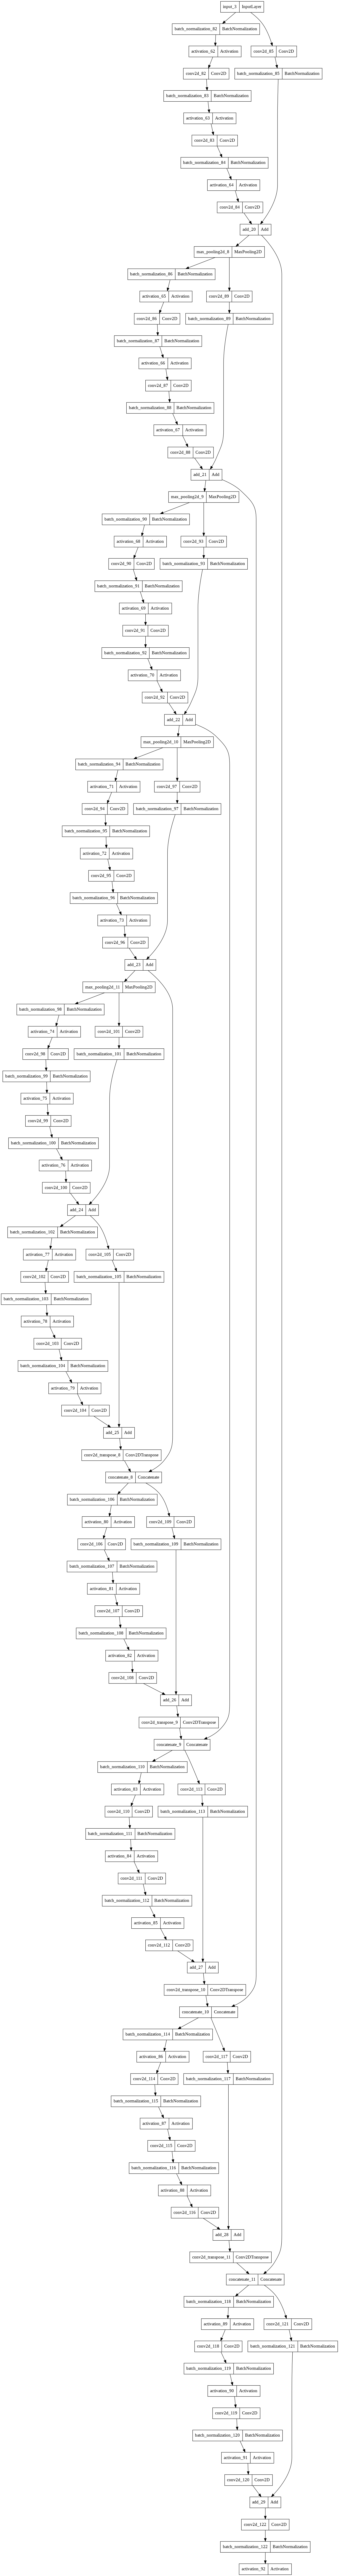

In [18]:
arch = ResUnet(input_size=image_size)
model_resunet = arch.build_model()
tf.keras.utils.plot_model(model_resunet,to_file='resunet_model.png')

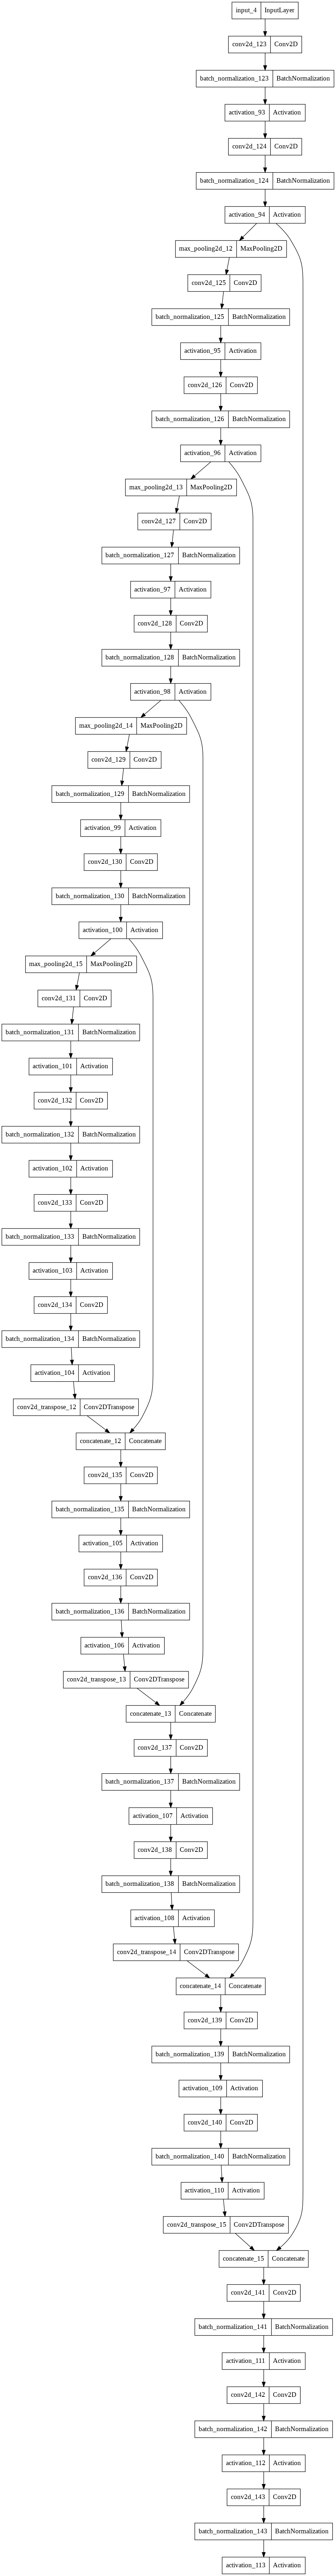

In [22]:
arch = Unet(input_size=image_size)
model_unet = arch.build_model()
tf.keras.utils.plot_model(model_unet,to_file='unet_model.png')

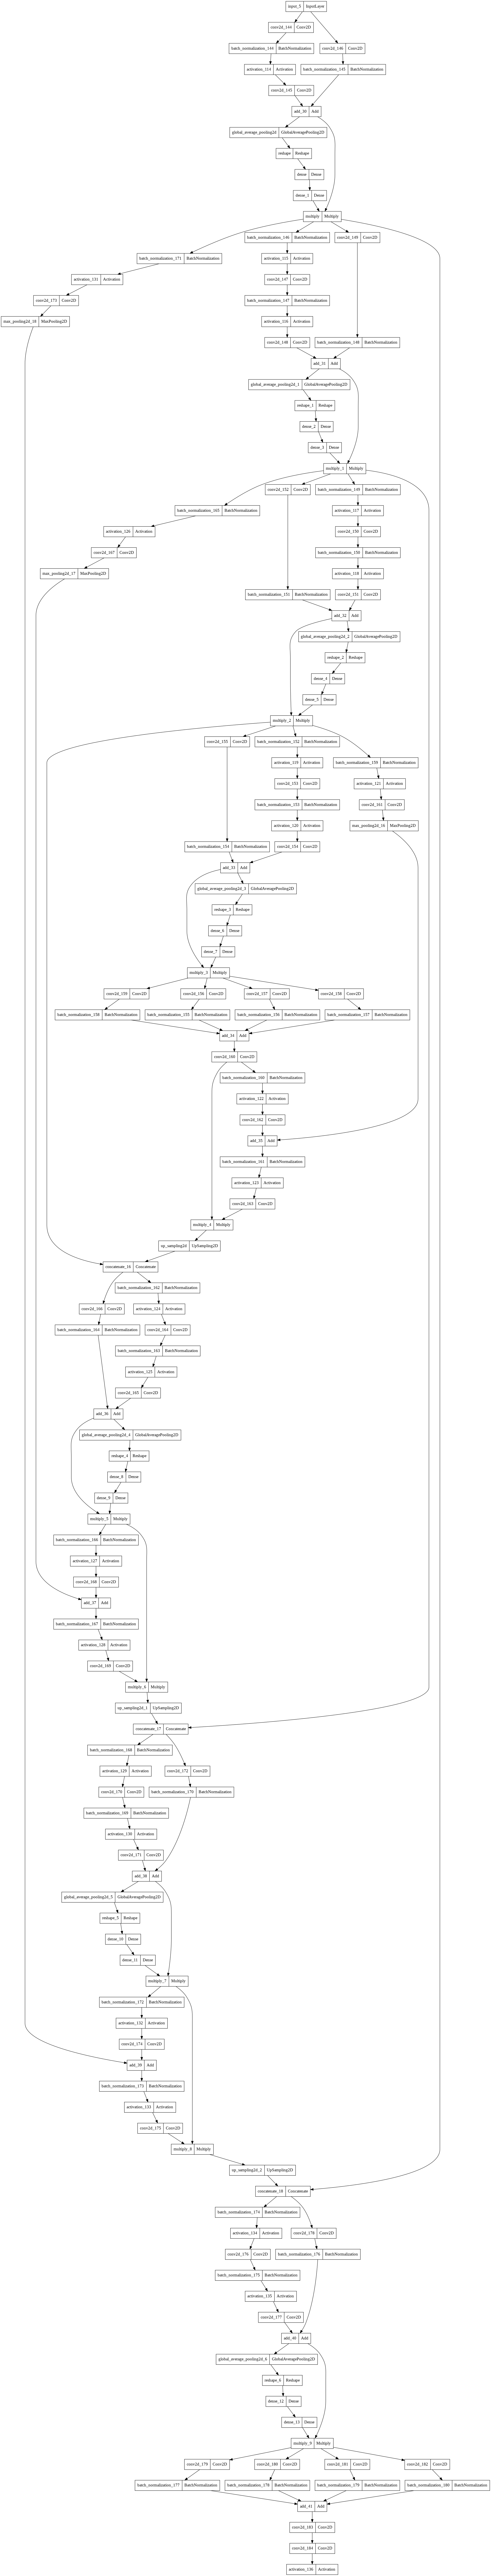

In [23]:
arch = ResUnetPlusPlus(input_size=image_size)
model_resunetplusplus = arch.build_model()
tf.keras.utils.plot_model(model_resunetplusplus,to_file='resunetplusplus_model.png')